# Introduction
In this notebook, we anaylze our national dataset to look for name trends.

In [139]:
#Import necessary libraries
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import mplcursors
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display, HTML
import dash
from dash import dcc, html
from dash.dependencies import Input, Output

## Load Data

In [140]:
#Load national data from SSA
national_df = pd.read_csv("Data/national_data.csv")
#Load state data from SSA
states_df = pd.read_csv("Data/states_data.csv")

### Trends in Names Over Time

In [141]:
#Create function to plot a single name over time
def plot_name_trend(df, name_to_plot):
    """
    Plot the trend of a specific name over time.

    Parameters:
        df (DataFrame): DataFrame containing name data.
        name_to_plot (str): Name for which the trend will be plotted.
    """
    # Filter data for the specified name
    name_data = df[df['name'] == name_to_plot]
    
    # Aggregate counts by year
    name_counts_by_year = name_data.groupby('year')['count'].sum().reset_index()

    # Plot the trend
    plt.figure(figsize=(10, 6))
    plt.plot(name_counts_by_year['year'], name_counts_by_year['count'], marker='o')

    # Add labels and title
    plt.title(f'Trend of Name "{name_to_plot}" Over Time')
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.grid(True)
    plt.show()

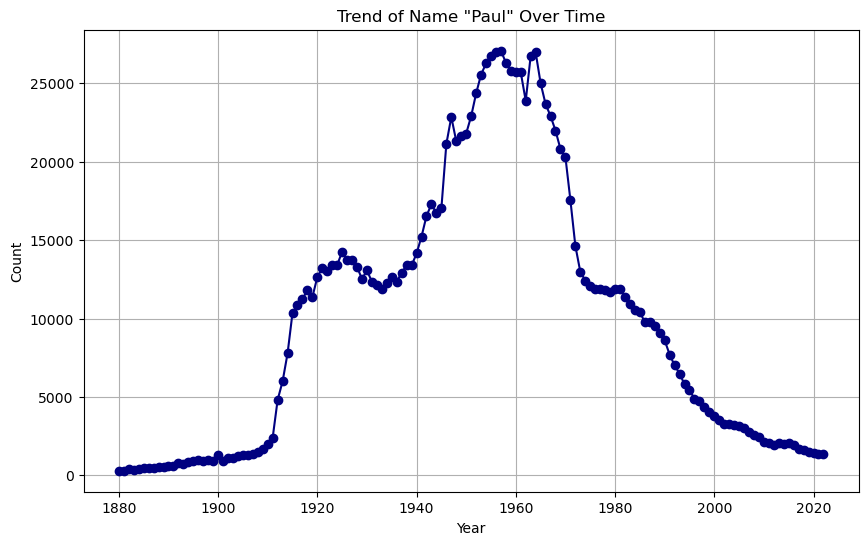

In [142]:
# Plot example name
plot_name_trend(national_df, 'Paul')

### Data by Name and Gender

In [143]:
def plot_name_over_time(df, name):
    """
    Plot occurrences of a single name by sex over time. 

    Parameters:
        df (DataFrame): DataFrame containing name data.
        name (str): Name in dataset
    """
    # Filter data for the specified name and separate by sex
    male_data = df[(df['name'] == name) & (df['sex'] == 'M')]
    female_data = df[(df['name'] == name) & (df['sex'] == 'F')]

    # Set custom colors for male and female
    colors = {'M': '#000080',  # Navy Blue for 'M'
              'F': '#FF69B4'}  # Hot Pink for 'F'

    # Plot occurrences over time for male and female
    plt.figure(figsize=(10, 6))
    plt.plot(male_data['year'], male_data['count'], label='Male', color=colors['M'])
    plt.plot(female_data['year'], female_data['count'], label='Female', color=colors['F'])
    
    # Add labels and title
    plt.title(f'Differences of Name "{name}" by Sex Over Time')
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True)
    plt.show()

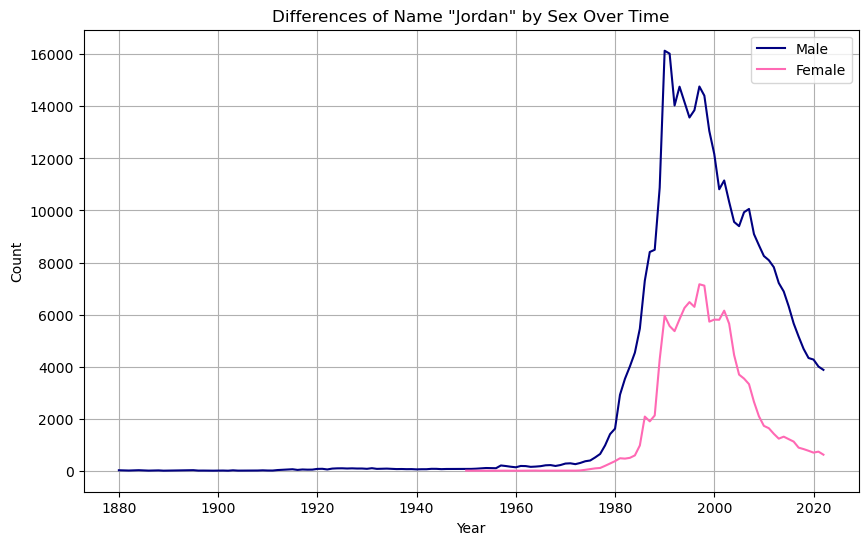

In [144]:
plot_name_over_time(national_df, 'Jordan')

In [145]:
def compare_names_across_genders(df, names_to_compare):
    """
    Compare the popularity of multiple names across genders.

    Parameters:
        df (DataFrame): DataFrame containing name data.
        names_to_compare (list): List of names to compare.
    """
    # Filter data for the specified names
    filtered_data = df[df['name'].isin(names_to_compare)]

    # Set custom color palette
    colors = {'M': '#000080',  # Navy Blue for 'M'
              'F': '#FF69B4'}  # Hot Pink for 'F'

    # Plot the comparison
    plt.figure(figsize=(10, 6))
    sns.barplot(data=filtered_data, x='name', y='count', hue='sex', palette=colors)
    plt.title('Popularity of Names Across Genders')
    plt.xlabel('Name')
    plt.ylabel('Count')
    plt.legend(title='Gender')
    plt.grid(True)
    plt.show()


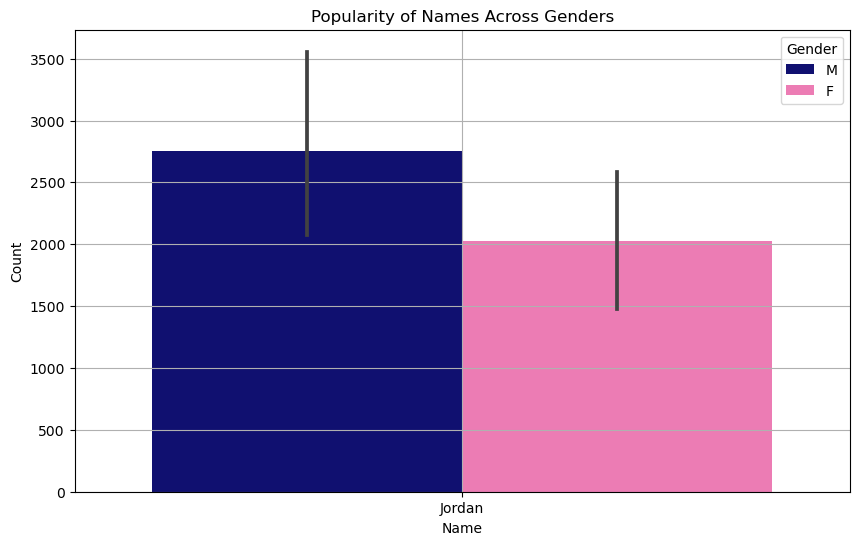

In [146]:
# Plot example names
compare_names_across_genders(national_df, ['Jordan', 'Jordan'])

### Top Names per Year

In [167]:
def plot_name_over_time(df, name):
    """
    Plot occurrences of a single name by sex over time. 

    Parameters:
        df (DataFrame): DataFrame containing name data.
        name (str): Name in dataset
    """
    # Filter data for the specified name
    name_data = df[df['name'] == name]

    # Set custom colors for male and female
    colors = {'M': 'blue', 'F': 'pink'}

    # Plot occurrences over time for male and female
    plt.figure(figsize=(10, 6))
    for sex, data in name_data.groupby('sex'):
        plt.plot(data['year'], data['count'], label=sex, color=colors)
    
    # Add labels and title
    plt.title(f'Occurrences of Name "{name}" by Sex Over Time')
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True)
    plt.show()

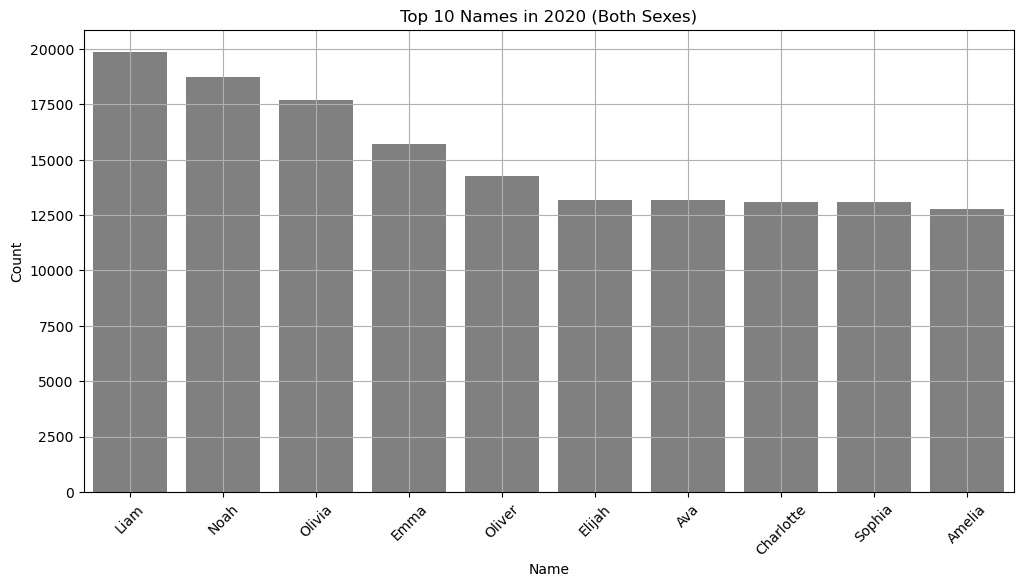

In [168]:
plot_top_names_in_year(national_df, 2020, sex=None, N=10)

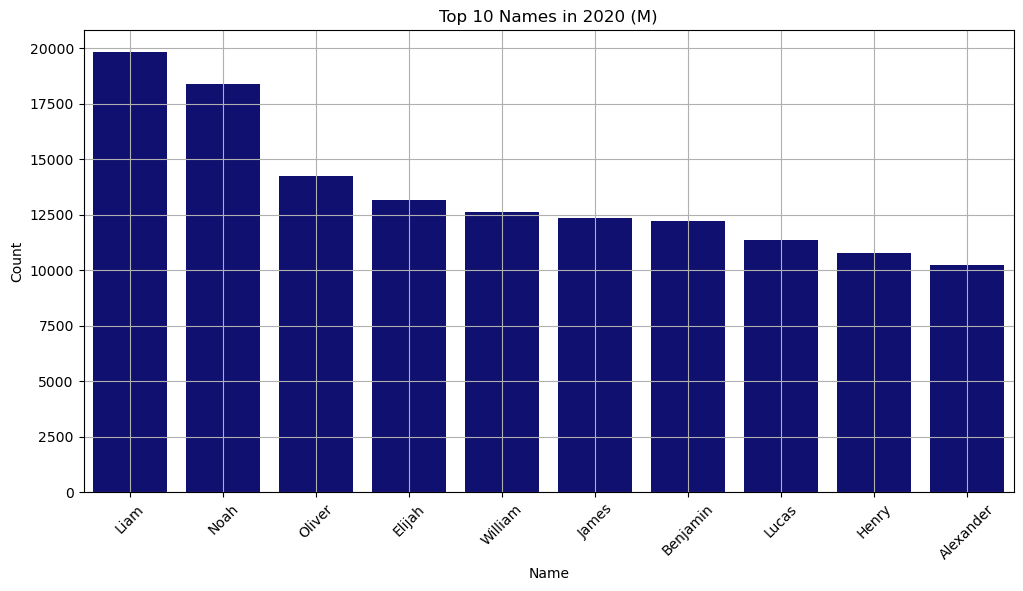

In [171]:
plot_top_names_in_year(names_df, 2020, sex='M', N=10)

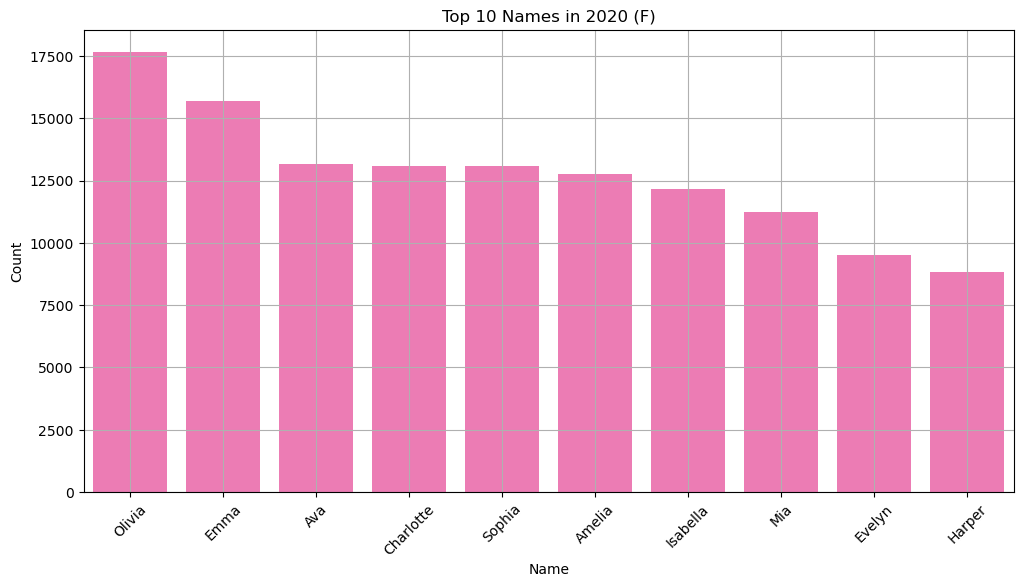

In [172]:
plot_top_names_in_year(names_df, 2020, sex='F', N=10)

### Create Dropdown

In [103]:
# Create a function to get the top 10 names for a given year and sex
def get_top_names(year):
    top_male_names = national_df[(national_df['sex'] == 'M') & (national_df['year'] == year)].nlargest(10, 'count')['name'].tolist()
    top_female_names = national_df[(national_df['sex'] == 'F') & (national_df['year'] == year)].nlargest(10, 'count')['name'].tolist()
    return top_male_names, top_female_names

# Create widget for selecting year
year_dropdown = widgets.Dropdown(options=national_df['year'].unique(), description='year:')

# Create function that updates the output widget when the year is changed
def update_output(year):
    top_male_names, top_female_names = get_top_names(year)
    output_widget.clear_output()
    with output_widget:
        display(HTML(f'<h3>Top 10 Male Names for {year}</h3><ul><li>{"</li><li>".join(top_male_names)}</li></ul>'))
        display(HTML(f'<h3>Top 10 Female Names for {year}</h3><ul><li>{"</li><li>".join(top_female_names)}</li></ul>'))

# Create an output widget for displaying the top names
output_widget = widgets.Output()

# Display the widgets
display(year_dropdown)
display(output_widget)

# Call the update_output function when the year is changed
widgets.interactive(update_output, year=year_dropdown)

Dropdown(description='year:', options=(1880, 1881, 1882, 1883, 1884, 1885, 1886, 1887, 1888, 1889, 1890, 1891,…

Output()

interactive(children=(Dropdown(description='year:', options=(1880, 1881, 1882, 1883, 1884, 1885, 1886, 1887, 1…

### Names with biggest increases

In [104]:
# Calculate the total count of each name for each year and sex
name_counts = national_df.groupby(['name', 'sex', 'year']).sum().reset_index()

# Calculate the percentage increase of each name from one year to the next
name_counts['percentage_increase'] = name_counts.groupby(['name', 'sex'])['count'].pct_change()

# Find the names with the highest percentage increase over time for both males and females
top_male_names = name_counts[name_counts['sex'] == 'M'].nlargest(10, 'percentage_increase')
top_female_names = name_counts[name_counts['sex'] == 'F'].nlargest(10, 'percentage_increase')

# Display the top male and female names with the biggest increases over time
print("Top 10 Male Names with the Biggest Increases Over Time:")
print(top_male_names[['name', 'percentage_increase']])

print("\nTop 10 Female Names with the Biggest Increases Over Time:")
print(top_female_names[['name', 'percentage_increase']])

Top 10 Male Names with the Biggest Increases Over Time:
             name  percentage_increase
1531941   Omarion            82.600000
1182705     Lavar            54.800000
864347     Jaheim            54.400000
59947    Alexande            49.166667
1898294     Tevin            45.692308
874387      Jalen            39.800000
506824     Demond            39.300000
974004     Jonael            37.666667
643317     Ermias            33.800000
938268   Jermaine            33.200000

Top 10 Female Names with the Biggest Increases Over Time:
            name  percentage_increase
1461145    Nakia           161.142857
902223   Jaslene            99.200000
1849306  Tabatha            99.000000
335949    Catina            96.928571
508748    Deneen            71.909091
42630    Akeelah            66.166667
1338     Aaliyah            64.954545
1118384   Kizzie            56.200000
1862115  Tamatha            43.400000
412605   Coraima            43.200000


### Name Popularity Dashboard

In [106]:
# Create Dash app
app = dash.Dash(__name__)

# Define layout of the dashboard
app.layout = html.Div([
    html.H1("Name Popularity Dashboard"),
    html.Div([
        dcc.Input(id='input-name', type='text', placeholder='Enter your name'),
        dcc.Input(id='input-year', type='number', placeholder='Enter your birth year'),
        html.Button('Submit', id='submit-button', n_clicks=0)
    ]),
    html.Div(id='output-rank'),
    html.Div(id='output-similar-name')
])

# Callback to calculate rank and find similar name
@app.callback(
    [Output('output-rank', 'children'),
     Output('output-similar-name', 'children')],
    [Input('submit-button', 'n_clicks')],
    [dash.dependencies.State('input-name', 'value'),
     dash.dependencies.State('input-year', 'value')]
)
def update_output(n_clicks, name, year):
    if n_clicks > 0:
        # Filter dataframe for the given year
        year_df = national_df[national_df['year'] == year]
        
        # Calculate rank of the given name
        rank = year_df[year_df['name'] == name]['count'].rank(ascending=False).iloc[0]
        
        # Find a name with the same rank in the dataframe
        similar_name = year_df[year_df['count'].rank(ascending=False) == rank]['name'].iloc[0]
        
        return f"Rank of {name} in {year}: {int(rank)}", f"A similar name in {year} with the same rank: {similar_name}"
    else:
        return '', ''

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True, port=8053)